In [13]:
import fiona
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pathlib
import shapely
from scipy import stats
from tqdm.notebook import tqdm

mpl.rcParams['figure.dpi'] = 144
mpl.style.use('scrartcl.mplstyle')

In [3]:
# Load all the data we need.
ROOT = pathlib.Path('data/wastewater_catchment_areas_public')

lsoas = gpd.read_file('data/geoportal.statistics.gov.uk/LSOA11_BGC.zip').set_index('LSOA11CD')

catchments = gpd.read_file(ROOT / 'catchments_consolidated.shp')

lsoa_catchment_lookup = pd.read_csv(ROOT / 'lsoa_catchment_lookup.csv')

lsoa_coverage = pd.read_csv(ROOT / 'lsoa_coverage.csv')

lsoa_population = pd.read_csv('data/ons.gov.uk/lsoasyoaallyearst.zip', usecols=['LSOA11CD', 'year', 'Pop_Total'])

lsoa_population['year'] = lsoa_population.year.apply(lambda x: int(x[4:]))

waterbase_catchment_lookup = pd.read_csv(ROOT / 'waterbase_catchment_lookup.csv')

waterbase_consolidated = pd.read_csv(ROOT / 'waterbase_consolidated.csv',
                                     index_col=['uwwCode', 'year'])
# Fix a data problem where someone dropped a zero (or another digit) for Kinmel Bay.
waterbase_consolidated.loc[('UKWAWA_WW_TP000093', 2016), 'uwwLoadEnteringUWWTP'] *= 10

# Add up the treated load for the two works in Abingdon (which should really just be one).
x = waterbase_consolidated.loc['UKENTH_TWU_TP000001'].uwwLoadEnteringUWWTP
y = waterbase_consolidated.loc['UKENTH_TWU_TP000165'].uwwLoadEnteringUWWTP
z = y.reindex(x.index).fillna(0) + x
waterbase_consolidated.loc['UKENTH_TWU_TP000001', 'uwwLoadEnteringUWWTP'] = z.values

# Get rid of the duplicate treatment work.
waterbase_consolidated = waterbase_consolidated.drop('UKENTH_TWU_TP000165', level=0)
waterbase_consolidated = waterbase_consolidated.reset_index()

In [4]:
lsoas.columns

Index(['OBJECTID', 'LSOA11NM', 'LSOA11NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'Shape__Are', 'Shape__Len', 'GlobalID', 'geometry'],
      dtype='object')

In [7]:
lsoa_population.columns

Index(['LSOA11CD', 'year', 'Pop_Total'], dtype='object')

In [9]:
# Evaluate the total intersection area for each LSOA.
intersection_area_sum = lsoa_catchment_lookup.groupby('LSOA11CD')\
    .intersection_area.sum().reset_index(name='intersection_area_sum')

# Construct a data frame that has a number of different areas that we can use for normalisation.
merged = pd.merge(lsoa_coverage, intersection_area_sum, on='LSOA11CD')
merged = pd.merge(merged, lsoa_catchment_lookup, on='LSOA11CD')
merged = pd.merge(merged, lsoa_population, on='LSOA11CD')

def aggregate(subset):
    # Construct different normalisations.
    # - for total area, we divide by the area of the LSOA.
    # - for area covered, we divide by the area of the LSOA that's covered by *any* 
    #   catchment.
    # - for intersection sum, we divide by the sum of all intersections. This may be
    #   larger than the area of the catchments if the data has overlapping catchments.
    norms = {
        'norm_total_area': subset.total_area,
        'norm_area_covered': subset.area_covered,
        'norm_intersection_sum': subset.intersection_area_sum,
    }
    intersection_area_pop = subset.intersection_area * subset.Pop_Total
    return pd.Series({key: (intersection_area_pop / value).sum() for key, value in norms.items()})

grouped = merged.groupby(['identifier', 'year'])
geospatial_estimate = grouped.apply(aggregate)
geospatial_estimate.head()

C:\Users\99787\AppData\Local\Temp\ipykernel_1804\192980483.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  geospatial_estimate = grouped.apply(aggregate)


norm_total_area  norm_area_covered  norm_intersection_sum
identifier year                                                           
000deaad90 2001       120.046374        1586.211726            1586.211726
           2002       120.581727        1582.510370            1582.510370
           2003       117.461098        1569.462118            1569.462118
           2004       115.816247        1561.085950            1561.085950
           2005       117.351143        1573.703630            1573.703630

In [11]:
# Generate summary for table 1 of the publication.
year = 2016
method = "norm_intersection_sum"

summary = geospatial_estimate.reset_index()
summary = summary[summary.year == year]
summary = pd.merge(catchments, summary, on="identifier")
summary = summary.groupby("company").apply(
    lambda subset: {
        "population": subset[method].sum() / 1e6,
        "retained_catchments": len(subset),
        "area": np.round(subset.geometry.area.sum() / 1e6),
        "matched_uwwtp": subset.identifier.isin(waterbase_catchment_lookup.identifier).sum(),
    }
).apply(pd.Series) 

frac = (
    1e6 * summary.population.sum() 
    / lsoa_population[lsoa_population.year == year].Pop_Total.sum()
)
print(f"fraction covered: {frac}")
print(f"total covered: {summary.population.sum()}m")
summary

fraction covered: 0.9518021352655256
total covered: 55.567367m


C:\Users\99787\AppData\Local\Temp\ipykernel_1804\4146230905.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = summary.groupby("company").apply(


,population,retained_catchments,area,matched_uwwtp
company,,,,
anglian_water,6.594582,1134.0,4126.0,314.0
northumbrian_water,2.658190,319.0,1302.0,66.0
severn_trent_water,8.885894,1003.0,2350.0,251.0
south_west_water,1.746308,673.0,870.0,91.0
southern_water,4.673176,372.0,1366.0,137.0
thames_water,13.170946,344.0,2348.0,150.0
united_utilities,6.881227,560.0,1829.0,141.0
welsh_water,3.251769,859.0,1120.0,122.0
wessex_water,2.881381,382.0,2096.0,115.0


In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# Merge the waterbase data (BOD p.e.) with geospatial population estimates for comparison.
merged = pd.merge(waterbase_catchment_lookup, waterbase_consolidated, on=['uwwCode', 'uwwName'])
merged = pd.merge(merged, geospatial_estimate, on=['year', 'identifier'])

# Sum by year and uwwCode (because the same treatment work may be linked to multiple catchments if
# the subcatchment aggregation didn't work out properly). Then assign back to the merged dataset and
# drop duplicates.
estimates = merged.groupby(['uwwCode', 'year']).agg({
    'norm_total_area': 'sum',
    'norm_area_covered': 'sum',
})

# Assign summed values back to merged
for key in estimates:
    merged[key] = [estimates.loc[(x.uwwCode, x.year), key] for _, x in merged.iterrows()]

# Drop duplicate entries
merged = merged.drop_duplicates(['uwwCode', 'year'])

# Export to CSV
merged.to_csv('geospatial_population_estimates.csv', index=False, encoding='utf-8')

# Evaluate the Pearson correlation on the log scale (omitting treatment works without load).
f = merged.uwwLoadEnteringUWWTP > 0
correlation = stats.pearsonr(np.log(merged.uwwLoadEnteringUWWTP[f]), np.log(merged[method][f]))

print("Pearson correlation:", correlation)
print("CSV file 'geospatial_population_estimates.csv' has been saved successfully!")

Pearson correlation: (0.9725409730475391, 0.0)
CSV file 'geospatial_population_estimates.csv' has been saved successfully!


Haggerston HAGGERSTON CASTLE CARAVAN PARK STW
Rotherwas ROTHERWAS STW FIR TREE LANE HFD STW
Billericay BILLERICAY STW


  0%|          | 0/6 [00:00<?, ?it/s]

[0.053719306314205933,
 0.05159318377605427,
 0.05081466595985465,
 0.04800762102031006,
 0.04796290124691944,
 0.04725031052647281]

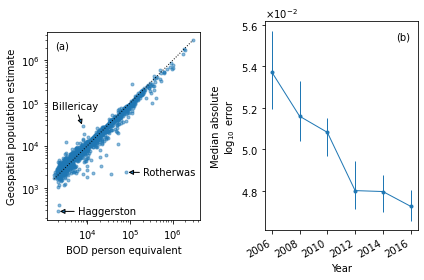

In [8]:
# Show a figure of different population estimates for a given year.
fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[:, 0])
year = 2016
subset = merged[merged.year == year]
ax.scatter(subset.uwwLoadEnteringUWWTP, subset[method], marker='.', alpha=.5)
ax.set_yscale('log')
ax.set_xscale('log')
lims = subset.uwwLoadEnteringUWWTP.quantile([0, 1])
ax.plot(lims, lims, color='k', ls=':')
ax.set_aspect('equal')
ax.set_xlabel('BOD person equivalent')
ax.set_ylabel('Geospatial population estimate')
ax.text(0.05, 0.95, '(a)', transform=ax.transAxes, va='top')

# Annotations.
annotations = [
    {
        'code': 'UKENNE_NU_TP000026',
        'label': 'Haggerston',
        'xfactor': 3,
        'yfactor': 1,
    },
    {
        'code': 'UKWAWA_WW_TP000016',
        'label': 'Rotherwas',
        'xfactor': 2.5,
    },
    {
        'code': 'UKENAN_AW_TP000020',
        'label': 'Billericay',
        'xfactor': 2/3,
        'yfactor': 3,
        'kwargs': {'ha': 'center'},
    },
#     {
#         'code': 'UKENAN_AW_TP000051',
#         'label': 'Chalton',
#         'xfactor': 1 / 3,
#         'kwargs': {'ha': 'right'},
#     },
]
indexed = subset.set_index('uwwCode')
for annotation in annotations:
    item = indexed.loc[annotation['code']]

    ax.annotate(
        annotation['label'],
        (item.uwwLoadEnteringUWWTP, item[method]),
        (item.uwwLoadEnteringUWWTP * annotation.get('xfactor', 1),
            item[method] * annotation.get('yfactor', 1)),
        arrowprops={
            'arrowstyle': '-|>',
        },
        va='center',
        **annotation.get('kwargs', {}),
    )
    print(annotation['label'], item.uwwName)

ax3 = ax = fig.add_subplot(gs[:, 1])
target = lambda x: np.median(np.abs(np.log10(x[method] / x.uwwLoadEnteringUWWTP)))

x = []
y = []
ys = []
for year, subset in tqdm(merged.groupby('year')):
    x.append(year)
    # Evaluate the statistic.
    y.append(target(subset))
    # Run a bootstrap sample.
    ys.append([target(subset.iloc[np.random.randint(len(subset), size=len(subset))])
               for _ in range(1000)])

ys = np.asarray(ys)
l, u = np.percentile(ys, [25, 75], axis=1)
ax.errorbar(x, y, (y - l, u - y), marker='.')
ax.ticklabel_format(scilimits=(0, 0), axis='y', useMathText=True)
ax.set_xlabel('Year')
ax.set_ylabel('Median absolute\n$\\log_{10}$ error')
ax.xaxis.set_ticks([2006, 2008, 2010, 2012, 2014, 2016])
plt.setp(ax.xaxis.get_ticklabels(), rotation=30, ha='right')
ax.text(0.95, 0.95, '(b)', transform=ax.transAxes, ha='right', va='top')

fig.tight_layout()
fig.savefig('population-estimates.pdf')

# Show the log10 median absolute error over time.
y

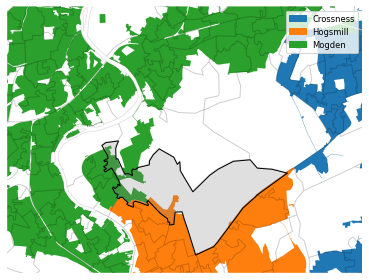

In [9]:
# Plot to illustrate why we're using area covered.
fig, ax = plt.subplots()

xmin = 515000
xmax = 523000
ymin = 170000
ymax = 176000
box = shapely.geometry.box(xmin, ymin, xmax, ymax)

# Plot the catchments.
idx_catchment = catchments.sindex.query(box)
subset = catchments.iloc[idx_catchment].sort_values('name')
subset = subset[subset.intersection(box).area > 10]
colors = ['C0', 'C1', 'C2']
subset.intersection(box).plot(ax=ax, color=colors)

# Plot the LSOAs.
idx = lsoas.sindex.query(box)
lsoas.iloc[idx].plot(ax=ax, facecolor='none', edgecolor='k', alpha=.1)
lsoas.loc[['E01003817']].plot(ax=ax, facecolor=(.5, .5, .5, .25), edgecolor='k')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_axis_off()
handles = [mpl.patches.Rectangle((0, 0), 1, 1, color=color) for color in colors]
labels = subset.name.str.replace(' STW', '').str.title()
ax.legend(handles, labels)

fig.tight_layout()
fig.savefig('estimation_method.pdf')

In [75]:
# calculate IMD pop and total pop for each UWWT sites

import numpy as np
import pandas as pd

# Read IMD data
imd_data = pd.read_csv("data/IMD2019.csv") 
# get population data of lsoa in 2015 (the IMD2019 data is literally for 2015)
lsoa_population_2015 = lsoa_population[lsoa_population.year == 2015]

# Calculate the total intersection area for each LSOA.
intersection_area_sum = lsoa_catchment_lookup.groupby('LSOA11CD')\
    .intersection_area.sum().reset_index(name='intersection_area_sum')

intersection_area_sum.head()
# intersection_area_sum.to_csv("data/intersection_area_sum.csv", index=True, encoding="utf-8")
# lsoa_population_2015.to_csv("data/lsoa_population_2015.csv", index=True, encoding="utf-8")

# merge the IMD and 2015 population of LSOA. Some LSOAs have no IMD decile 
lsoa_imd_population = pd.merge(lsoa_population_2015, imd_data[["LSOA11CD", "IMD_Decile"]], on="LSOA11CD")
# lsoa_imd_population.to_csv("data/lsoa_imd_population.csv", index=True, encoding="utf-8")

# merge the IMD/population/catchment ID/total intersection area of LSOA
merged = pd.merge(lsoa_catchment_lookup, lsoa_imd_population, on="LSOA11CD")
# merged.to_csv("data/merged_1.csv", index=True, encoding="utf-8")
merged = pd.merge(merged, intersection_area_sum, on='LSOA11CD')
# merged.to_csv("data/merged_2.csv", index=True, encoding="utf-8")

# calculate estimated population of catchment
merged["estimated_population"] = (merged["intersection_area"] / merged["intersection_area_sum"]) * merged["Pop_Total"]
# merged.to_csv("data/merged_3.csv", index=True, encoding="utf-8")

merged.head()

,identifier,LSOA11CD,intersection_area,year,Pop_Total,IMD_Decile,intersection_area_sum,estimated_population
0,6e237d7d4f,E01021768,177231.272895,2015,2190,6,1.137313e+06,341.274904
1,6e237d7d4f,E01021769,160934.444886,2015,2241,5,1.169821e+06,308.298558
2,6e237d7d4f,E01021796,157677.752105,2015,2168,5,7.792890e+05,438.663176
3,a3aea16d4a,E01028691,245795.515753,2015,1402,6,2.457955e+05,1402.000000
4,a3aea16d4a,E01028702,263935.503395,2015,1247,9,2.639355e+05,1247.000000


In [79]:
# calculate IMD pop for each catchment
imd_distribution = merged.groupby(["identifier", "IMD_Decile"])["estimated_population"].sum().unstack(fill_value=0)

# calculate estimated pop of each catchment
total_population = merged.groupby("identifier")["estimated_population"].sum().rename("total_estimate_pop")

# rename IMD columns
imd_distribution.columns = [f"pop_IMD_{int(col)}" for col in imd_distribution.columns]

# merge estimated pop data
imd_distribution = imd_distribution.merge(total_population, on="identifier")

# save to csv
imd_distribution.to_csv("data/catchment_IMD_2019_pop.csv", index=True, encoding="utf-8")

imd_distribution.head()

,pop_IMD_1,pop_IMD_2,pop_IMD_3,pop_IMD_4,pop_IMD_5,pop_IMD_6,pop_IMD_7,pop_IMD_8,pop_IMD_9,pop_IMD_10,total_estimate_pop
identifier,,,,,,,,,,,
000deaad90,0.0,0.000000,0.000000,0.000000,0.000000,126.558900,1294.539283,0.000000,168.267929,0.00000,1589.366112
002b4939d1,0.0,0.000000,0.000000,0.000000,0.000000,359.631013,2.355889,579.586135,0.000000,0.00000,941.573037
002d3b2ccf,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,453.53814,453.538140
00310b4c3b,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,571.703069,0.000000,0.00000,571.703069
0040dfa94f,1803.0,2838.868767,4729.777128,6350.133096,1501.313522,2346.951323,298.935715,0.000000,0.000000,0.00000,19868.979551


In [91]:
# Merge the waterbase data (BOD p.e.) with geospatial population estimates for comparison.
waterbase_consolidated_2016 = pd.read_csv(ROOT / 'waterbase_consolidated_2016.csv',
                                     index_col=['uwwCode', 'year'])

merged = pd.merge(waterbase_catchment_lookup, waterbase_consolidated_2016, on=['uwwCode', 'uwwName'])
# merged.to_csv("data/merged_3.5.csv", index=True, encoding="utf-8")

merged = pd.merge(merged, imd_distribution, on=['identifier'])
# # merged.to_csv("data/merged_4.csv", index=True, encoding="utf-8")

# aggregate by uwwCode, calculate the IMD pop and total pop for each UWWT site
imd_columns = [col for col in imd_distribution.columns if col.startswith("pop_IMD_")]  # find all IMD col
agg_columns = imd_columns + ["total_estimate_pop"]  # the cols need to be aggregated: IMD pop and total estimated pop

estimates = merged.groupby("uwwCode")[agg_columns].sum()  # sum up according to uwwCode group

# re-merge to 'merged', keep other columns
final_merged = pd.merge(merged.drop(columns=agg_columns).drop_duplicates("uwwCode"), estimates, on="uwwCode")

final_merged.to_csv("data/UWWT_IMD_estimated_pop.csv", index=True, encoding="utf-8")
final_merged.head()

,identifier,name,uwwCode,uwwName,distance,uwwState,rptMStateKey,uwwLatitude,uwwLongitude,uwwLoadEnteringUWWTP,...,pop_IMD_2,pop_IMD_3,pop_IMD_4,pop_IMD_5,pop_IMD_6,pop_IMD_7,pop_IMD_8,pop_IMD_9,pop_IMD_10,total_estimate_pop
0,db0c16f480,Acle-Damgate Lane,UKENAN_AW_TP000001,ACLE STW,0.000000,active,UK,52.632768,1.555557,3813.0,...,0.000000e+00,0.000000,8.734060,529.599183,1366.000000,632.379201,0.000000,1410.0000,0.000000,3946.712444
1,9993422f66,Alconbury,UKENAN_AW_TP000002,ALCONBURY STW,0.000000,active,UK,52.364693,-0.249934,5170.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,197.717255,2905.275125,0.0000,0.000000,3102.992381
2,a96313b815,Alford,UKENAN_AW_TP000003,ALFORD STW,0.000000,active,UK,53.260330,0.187425,3693.0,...,1.074973e-07,3417.037692,919.559618,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,4336.597310
3,4fc3fdb9d5,Anwick,UKENAN_AW_TP000004,ANWICK STW,0.000000,active,UK,53.035705,-0.338785,26524.0,...,0.000000e+00,401.588598,1690.000000,0.000000,0.000000,2.589364,1763.000000,2042.6444,0.000000,5899.822363
4,f61660381b,Ashbrook,UKENAN_AW_TP000005,ASHBROOK STW,84.433271,active,UK,51.935071,-0.253607,3837.0,...,0.000000e+00,0.000000,0.000000,3.635294,2703.583645,0.000000,476.612787,0.0000,403.477278,3587.309003
